# DEMO: Predicting day-ahead energy consumption

In [4]:
from datetime import datetime as dt, timedelta
import pandas as pd
import numpy as np
import loadForecast as lf
import mpld3
mpld3.enable_notebook()
%matplotlib inline

In [5]:
f = 'data/NORTH.csv'
df = pd.read_csv(f)
all_X = lf.makeUsefulDf(df).to_numpy()
all_y = df['load'].to_numpy()
# convert boolean features into float32 variables
all_X = np.asarray(all_X).astype(np.float32)
#print(all_X.shape, all_y.shape)
#print(all_X, all_y)

In [ ]:
predictions, accuracy = lf.neural_net_predictions(all_X, all_y)

Percent accuracy (MAPE). Train: 96.21041632430659.  Test: 96.15782174788617


<AxesSubplot:title={'center':'NCENT Texas 2018: prediction v. actual load'}>

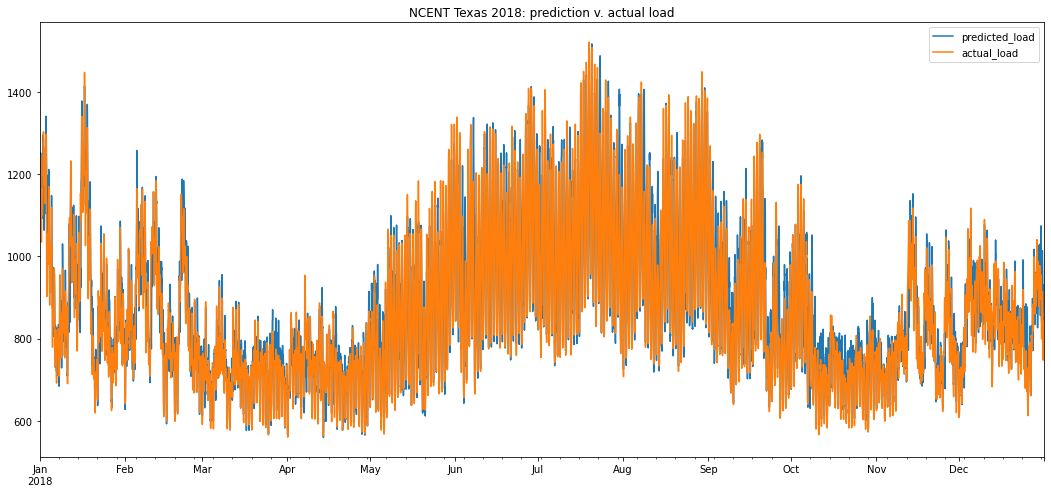

In [16]:
print('Percent accuracy (MAPE). Train: {}.  Test: {}'.format(100-accuracy['train'], 100-accuracy['test']))

df_r = pd.DataFrame()
df_r['predicted_load'] = predictions
df_r['actual_load'] = [float(f) for f in all_y[-8760:]]
df_r.index = [dt(2018, 1, 1, 0) + timedelta(hours=1)*i for i in range(8760)]
df_r.plot(figsize=(18, 8), title="NCENT Texas 2018: prediction v. actual load")

The new structure effectively combines 24 hourly models. But instead of calculating a single hour, we combine all weights into one flat, fully-connected dense layer (we settled on approx. 900 nodes). That layer is then fully connected to a 24-hour vector. 

In [8]:
def data_transform(data, timesteps, var='x'):
  m = []
  
  for i in range(data.shape[0]-timesteps):
      m.append(data[i:i+timesteps].tolist())

  if var == 'x':
      t = np.zeros((len(m), len(m[0]), len(m[0][0])))
      for i, x in enumerate(m):
          for j, y in enumerate(x):
              for k, z in enumerate(y):
                  t[i, j, k] = z
  else:
      t = np.zeros((len(m), len(m[0])))
      for i, x in enumerate(m):
          for j, y in enumerate(x):
              t[i, j] = y

  return t

In [9]:
HOURS_AHEAD = 24
all_y_rnn = data_transform(all_y, HOURS_AHEAD, var='y')
all_X_rnn = data_transform(all_X, HOURS_AHEAD, var='x')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow import keras

s = all_X.shape[1]
model_dayAhead = Sequential()
model_dayAhead.add(Dense(s, activation="relu", input_shape=(HOURS_AHEAD, s)))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Dense(s, activation="relu"))
model_dayAhead.add(Flatten())
model_dayAhead.add(Dense(s*HOURS_AHEAD//2, activation="relu"))
model_dayAhead.add(Dense(HOURS_AHEAD))

nadam = keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model_dayAhead.compile(optimizer=nadam, loss='mape')